# ENZYME CLASSIFICATION

The automated annotation of the enzymatic functions of uncharacterized proteins has a broad range of applications. Enzymes are classified by the nomenclature Committee of the International Union of Biochemistry into Enzyme Comission (EC) numbers, a four digit numerical representation separated by periods (e.g. 2.6.1.9). 
The four levels of EC numbers are related to each other in a functional hierarchy. The first number describes one of the 7 main
enzymatic classes, the second describes the subclass, the third represents the sub-subclass and the fourth refers to the substrate of the enzyme.
Several methods have been developed to accurately predict enzyme classes, with the majority using the raw one-hot encoding of the sequence or PSSM features. One should take into consideration that most of these methods do not include the class 7 of enzymes, translocases, as it was only introduced in 2018.
Here, encoding sequences using features based on the presence of PFAM domains or on the physicochemical properties are used to demonstrate that, using simple DNNs (architectures with stacked Dense layers), it is possible to obtain competitive enzyme classification predictive models.

1. DATASETS
The datasets used were retrieved from the ECPred study, which were filtered using the UNIPROT Uniref 90 (thus avoiding the existence of sequences with over 90% similarity), while the EC numbers were updated to the most recent ones. The PFAM domains were also retrieved from Uniprot.
This dataset is composed of 23245 negative sequences and 152560 enzyme sequences distributed along the 7 classes. 
The datasets were divided into training set (60% of the examples), a validation set (20%) and test set (20%).

2. FEATURES
To calculate the features, two approaches were used.
Firstly, the PFAM domains were one-hot encoded. 
Secondly, all the features available in ProPythia (except binaries, NLF and BLOSUM encodings) were calculated and each protein was described as a vector of length 9469.

3. CLASSES
These two input features were tested and the metrics assessed for classification of the sequences. 
EC main classes, EC numbers until the second digit and EC numbers until the third digit were analysed. Only classes with more
than 50 sequences were considered. For the main class, first level, 8 classes are predicted. For the second level (EC numbers complete until the second digit), 60 classes are identified. The third (EC numbers complete until the third digit)
contains 157 classes. All the levels include all the negative samples. Single label were considered. Classes with one EC or if more, with that EC level equal.

4. MODELS
Physicochemical features were fed into a DNN with two hidden layers with 1024 and 128 units, each followed by a Dropout layer (rate of 0.3) and Batch Normalization. 

PFAM encodings were fed into a similar DNN with 512 and 256 units in the hidden layers. 

The networks were trained using a batch size of 256 and 500 epochs with early stopping and reduce learning callbacks parameters (default parameters in ProPythia). The parameters not described here, were set as the Tensorflow/ Keras default

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
import operator
import random
import re
import pandas as pd
import numpy as np
from random import sample
from collections import Counter
from itertools import chain

import logging
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
logging.getLogger("tensorflow").setLevel(logging.ERROR)
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
from tensorflow import keras


os.environ["CUDA_VISIBLE_DEVICES"] = '7'
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.debugging.set_log_device_placement(True)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # tf.config.experimental.set_visible_devices(gpus[:1], 'GPU')

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,  MultiLabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.feature_selection import mutual_info_classif

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.utils import to_categorical
from keras.preprocessing import sequence
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dropout,  Concatenate, Flatten, BatchNormalization
from tensorflow.keras.layers import Dense, LSTM, Embedding, TimeDistributed, Bidirectional,ConvLSTM2D
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPool1D, MaxPool2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Model

sys.path.append('../../src/')
from propythia.feature_selection import FeatureSelection
from propythia.deep_ml import DeepML
from propythia.manifold import Manifold
from propythia.adjuv_functions.ml_deep.utils import divide_dataset, binarize_labels
from propythia.deep_ml import DeepML

1 Physical GPUs, 1 Logical GPUs


To ease the process, we define a set fo functions to easily retrieve the classes ( fps_y) of different levels wth more than 50 classes

In [2]:
# 1.Top 1000 classes complete classes
def get_ec_complete_more_than_x_samples(data, x=50, single_label=True):
    # get only EC COMPLETE
    data = data.dropna(subset=['ec_number'])

    l = []
    for ec_list in data['ec_number']:
        ec_complete = [x.strip() for x in ec_list.split(';') if "-" not in x]
        l.append(list(set(ec_complete)))

    data['ec_number4'] = l
    # remove lines without ec complete
    data = data.loc[data['ec_number4'].apply(len)>0,:]  # (153672, 59)
    print(data.shape)
    if single_label:
        data = turn_single_label('ec_number4', data)
        print(data.shape)
    else:
        pass

    # result = {x for l in data['ec_number4'] for x in l} #4603 differennt unique values
    # result_2 = set(chain(*data['ec_number4'])) # 4603 unique values
    counts = Counter(x for xs in data['ec_single_label'] for x in set(xs))
    counts.most_common()
    df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
    df_sorted = df.sort_values(by=[0], ascending=False)

    # # + de 1000 -
    # df_1000 = df.loc[df[0]>1000] # 5
    # # + de 500 -
    # df_500 = df.loc[df[0]>500] #20
    # # + de 300 -
    # df_300 = df.loc[df[0]>300] #115
    # # + de 100
    # df_100 = df.loc[df[0]>100] # 344
    # # + de 50 -
    # df_50 = df.loc[df[0]>50] # 536
    # # + de 30
    # df_30 = df.loc[df[0]>300] # 709
    # # + de 15
    # df_15 = df.loc[df[0]>15] #1069

    # + de x samples -
    df_15 = df.loc[df[0]>x] # 5
    #select the EC numbers that have more than ....
    l = []
    for ec_list in data['ec_number4']:
        ec = [x for x in ec_list if x in (list(df_15['index']))]
        l.append(ec)
    data['ec_number4'] = l # data 153672
    data = data.loc[data['ec_number4'].apply(len)>0,:] #142092
    counts = Counter(x for xs in data['ec_number4'] for x in set(xs))
    counts.most_common()

    df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
    df_sorted = df.sort_values(by=[0], ascending=False)
    print(df_sorted)
    return data   # column to consider is 'ec_number

##############
# get all the 3º level ec numbers complete with more than x samples
def get_ec_3_level_more_than_x_samples(data, x, single_label=True):
    # get all until the 3 level (everything until the last dot    175805
    # data = data.dropna(subset=['ec_number'])
    data['ec_number'] = data['ec_number'].replace(to_replace = '0', value = '0.0.0.0')
    l = []
    for ec_list in data['ec_number']:
        ec_3 = [re.match(r'.*(?=\.)',x).group(0) for x in ec_list.split(';')]
        l.append(list(set(ec_3)))
    data['ec_number3']=l
    # get only 3º level complete (remove dashes)
    l = []
    for ec_list in data['ec_number3']:
        ec_complete = [x.strip() for x in ec_list if "-" not in x]
        l.append(ec_complete)

    data['ec_number3'] = l
    # remove lines without ec complete
    data = data.loc[data['ec_number3'].apply(len)>0,:]  # 170191

    if single_label:
        data = turn_single_label('ec_number3', data)
    else:
        pass


    counts = Counter(x for xs in data['ec_number3'] for x in set(xs))
    counts.most_common()

    df = pd.DataFrame.from_dict(counts, orient='index').reset_index()  #256 classes
    df_sorted = df.sort_values(by=[0], ascending=False)


    # # + de 1000 -
    # df_1000 = df.loc[df[0]>1000] # 41
    # # + de 500 -
    # df_500 = df.loc[df[0]>500] # 67
    # # + de 300 -
    # df_300 = df.loc[df[0]>300] #95
    # # + de 100
    # df_100 = df.loc[df[0]>100] # 131
    # # + de 50 -
    # df_50 = df.loc[df[0]>50] # 160
    # # + de 30
    # df_30 = df.loc[df[0]>300] # 95
    # # + de 15
    # df_15 = df.loc[df[0]>15] #199

    # - de 15
    # df_15 = df.loc[df[0]<15] 55


    # + de x samples -
    df_15 = df.loc[df[0]>x]

    #select the EC numbers that have more than ....
    l = []
    for ec_list in data['ec_number3']:
        ec = [x for x in ec_list if x in(list(df_15['index']))]
        l.append(ec)
    data['ec_number3'] = l # data 153672
    data = data.loc[data['ec_number3'].apply(len)>0,:] #142092
    return data

##############
# get all the 2º level ec numbers complete with more than x samples
def get_ec_2_level_more_than_x_samples(data, x, single_label=True):
    # get all until the 2 level (everything until the last dot    175805
    l = []
    for ec_list in data['ec_number']:
        ec_2 = [re.search(r'[^.]*.[^.]*',x).group(0) for x in ec_list.split(';') ]
        # [^,]* = as many non-dot characters as possible,
        # . = a dot
        # [^.]* = as many non-dot characters as possible
        l.append(list(set(ec_2)))
    data['ec_number2']=l

    # get only 2º level complete (remove dashes)
    l = []
    for ec_list in data['ec_number2']:
        ec_complete = [x.strip() for x in ec_list if "-" not in x]
        l.append(ec_complete)

    data['ec_number2'] = l
    # remove lines without ec complete
    data = data.loc[data['ec_number2'].apply(len)>0,:]  # 174521

    if single_label:
        data = turn_single_label('ec_number2', data)
    else:
        pass


    counts = Counter(x for xs in data['ec_number2'] for x in set(xs))
    counts.most_common()

    df = pd.DataFrame.from_dict(counts, orient='index').reset_index()  #73 classes
    df_sorted = df.sort_values(by=[0], ascending=False)


    # # + de 1000 -
    # df_1000 = df.loc[df[0]>1000] # 27
    # # + de 500 -
    # df_500 = df.loc[df[0]>500] # 39
    # # + de 300 -
    # df_300 = df.loc[df[0]>300] # 45
    # # + de 100
    # df_100 = df.loc[df[0]>100] # 55
    # # + de 50 -
    # df_50 = df.loc[df[0]>50] # 60
    # # + de 30
    # df_30 = df.loc[df[0]>300] # 45
    # # + de 15
    # df_15 = df.loc[df[0]>15] # 64

    # - de 15
    # df_15 = df.loc[df[0]<15] 7


    # + de x samples -
    df_x = df.loc[df[0]>x]

    #select the EC numbers that have more than ....
    l = []
    for ec_list in data['ec_number2']:
        ec = [x for x in ec_list if x in(list(df_x['index']))]
        l.append(ec)
    data['ec_to_keep'] = l # data 153672
    data = data.loc[data['ec_to_keep'].apply(len)>0,:]
    return data


##############
# get all the 1º level ec numbers complete
def get_ec_1_level(data, single_label=True):
    # get all until the 1 level (everything until the last dot    175805
    l = []
    for ec_list in data['ec_number']:
        ec_1 = [x.strip()[0] for x in ec_list.split(';') ]
        # [^,]* = as many non-dot characters as possible,
        # . = a dot
        l.append(list(set(ec_1)))
    data['ec_number1']=l
    if single_label:
        data = turn_single_label('ec_number1', data)
    else:
        pass

    counts = Counter(x for xs in data['ec_number1'] for x in set(xs))
    counts.most_common()
    df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
    df_sorted = df.sort_values(by=[0], ascending=False)

    # [('2', 54508),
    #  ('3', 34838),
    #  ('0', 23245),
    #  ('1', 19200),
    #  ('6', 16307),
    #  ('4', 13163),
    #  ('5', 8105),
    #  ('7', 6957)]

    return data


functions to get the features

In [3]:
def hot_encoded_families(data, column_parameter='Cross-reference (Pfam)'):
    # divide parameter
    families = data[column_parameter]

    # remove columns with parameter NAn
    # data2 = data[data[column_parameter].notna()] # from 175267 to 167638

    fam = [i.split(';') for i in data[column_parameter]]  # split dos Pfam 'PF01379;PF03900;'
    fam = [list(filter(None, x)) for x in fam]  # remove '' empty string (because last ;
    # fam = [set(x) for x in fam]

    mlb = MultiLabelBinarizer()
    fam_ho = mlb.fit_transform(fam)
    classes = mlb.classes_
    len(classes)
    return data, fam_ho, classes

def physchemical(data):
    not_x = ['ec_number_ecpred', 'uniprot', 'sequence', 'uniref_90', 'ec_number']
    fps_x = data.drop(not_x, axis=1)
    columns = fps_x.columns
    return data, fps_x, columns

In [4]:
########################################################################################################################
#################################################### OTHERS ############################################################
########################################################################################################################
def turn_single_label(column, data):
    l = []
    for ec_list in data[column]:
        ec_l = set(ec_list)
        l.append(ec_l)
    data['ec_single_label']=l
    data = data.loc[data['ec_single_label'].apply(len)<2,:]
    return data

def remove_zeros(column, data):
    list_zeros=[0, 0.0, '0', '0.0', '0.0.0', '0.0.0.0']
    l = []
    for ec_list in data[column]:
        ec_l = [x for x in ec_list if x not in (list_zeros)]
        l.append(ec_l)
    data['non_negative'] =l

    data = data.loc[data['non_negative'].apply(len)>0,:]
    return data

# get columns names with number_aa
def column_name_sequence(len_seq, alphabet):
    columns = []
    count=1
    aa=1
    for x in range(len_seq*len(alphabet)):
        s='{}_{}'.format(count, aa)
        count+=1
        aa+=1
        if aa == len(alphabet)+1:
            aa = 1
        columns.append(s)
        
    return columns

def divide_dataset(fps_x, fps_y, test_size=0.2, val_size=0.1):
    # divide in train, test and validation
    x_train_1, x_test, y_train_1, y_test = train_test_split(fps_x, fps_y, test_size=test_size,random_state=42, shuffle=True, stratify=fps_y)

    # iterative_train_test_split(fps_x, fps_y, test_size=test_size)
    train_percentage = 1 - test_size
    val_size = val_size/train_percentage

    x_train, x_dval, y_train, y_dval = train_test_split(x_train_1, y_train_1, test_size=val_size, random_state=42, shuffle=True, stratify=y_train_1)

    # stratify=y_train_1, shuffle=True)

    return x_train, x_test, x_dval, y_train, y_test, y_dval

def normalization(x_train, x_test, x_dval):
    std_scale = StandardScaler().fit(x_train)
    x_train_std = std_scale.transform(x_train)
    x_test_std = std_scale.transform(x_test)
    x_dval_std = std_scale.transform(x_dval)

    # fps_x_std= StandardScaler().fit_transform(fps_x)
    return x_train_std, x_test_std, x_dval_std


# BINARIZE LABELS
def binarize_labels(fps_y): # for single
    test = pd.Series(fps_y)

    # mlb = MultiLabelBinarizer()
    # hot = mlb.fit_transform(test)
    # res = pd.DataFrame(hot,
    #                    columns=mlb.classes_,
    #                    index=test.index)
    fps_y = [item for sublist in fps_y for item in sublist] # this line is because they are retrieved as a list
    encoder = LabelEncoder()
    encoder.fit(fps_y)
    encoded_Y = encoder.transform(fps_y)
    classes = encoder.classes_
    fps_y = np_utils.to_categorical(encoded_Y) # convert integers to dummy variables (i.e. one hot encoded)

    # print(fps_y)
    # print(fps_y.shape)

    from sklearn.preprocessing import OneHotEncoder
    # creating instance of one-hot-encoder
    # enc = OneHotEncoder(handle_unknown='ignore')
    # # passing bridge-types-cat column (label encoded values of bridge_types)
    # enc_df = pd.DataFrame(enc.fit_transform(bridge_df[['Bridge_Types_Cat']]).toarray())
    # # merge with main df bridge_df on key values
    # bridge_df = bridge_df.join(enc_df)
    # bridge_df
    # bridge_types = list(set(fps_y))
    # bridge_df = pd.DataFrame(bridge_types, columns=['EC'])
    # # generate binary values using get_dummies
    # dum_df = pd.get_dummies(bridge_df, columns=["EC"], prefix=["Type_is"])
    # # merge with main df bridge_df on key values
    # bridge_df = bridge_df.join(dum_df)
    # print(bridge_df)

    return encoded_Y, fps_y, classes


1. Physchemical 
To ease, the file with calculated features is given below. This dataset is already preprocessed. (To see how the features are calculated AMP notebooks can be checked)

In [5]:
phys_90 = pd.read_csv('datasets/ecpred_phys_uniref_90_prepro.csv', low_memory=False)
phys_90

,lenght,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,tot,hydrogen,...,arc_0,arc_1,arc_2,arc_3,arc_4,ec_number_ecpred,uniprot,sequence,uniref_90,ec_number
0,313.0,-6.002,-0.000174,1497.0,2457.0,411.0,475.0,17.0,5609.0,3136.0,...,120.0,180.0,60.0,60.0,20.0,2.5.1.61,Q65GK1,MRNIIVGSRRSKLAMTQTKWVIKKLEELNPDFTFEIKEIVTKGDRI...,Q65GK1,2.5.1.61
1,314.0,-6.197,-0.000178,1518.0,2492.0,412.0,480.0,16.0,5672.0,3173.0,...,140.0,200.0,60.0,40.0,20.0,2.5.1.61,P16616,MMRTIKVGSRRSKLAMTQTKWVIQKLKEINPSFAFEIKEIVTKGDR...,P16616,2.5.1.61
2,311.0,0.345,0.000010,1502.0,2458.0,420.0,453.0,12.0,5596.0,3134.0,...,200.0,180.0,60.0,60.0,20.0,2.5.1.61,Q1LU25,MLNNILKIATRQSPLAIWQANYVRNQLLSFYPTLLIELVPIVTSGD...,Q1LU25,2.5.1.61
3,311.0,13.654,0.000390,1554.0,2539.0,423.0,458.0,11.0,5798.0,3241.0,...,140.0,160.0,60.0,60.0,20.0,2.5.1.61,Q7VRM4,MQAKILRIATRKSPLAICQACYVCNKLKHYHPHIQTELIPIITTGD...,Q7VRM4,2.5.1.61
4,300.0,5.666,0.000167,1509.0,2437.0,411.0,446.0,9.0,5565.0,3099.0,...,140.0,140.0,60.0,40.0,20.0,2.5.1.61,Q491Z6,MKNKILKIATRKSQLAICQAQYVHNELKHYHPTLSIELMPIVTTGD...,Q491Z6,2.5.1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175228,448.0,-10.198,-0.000197,2323.0,3595.0,585.0,705.0,18.0,8291.0,4550.0,...,160.0,200.0,60.0,100.0,40.0,non_Enzyme,Q8R121,MRVASSLFLPVLLTEVWLVTSFNLSSHSPEASVHLESQDYENQTWE...,Q8R121,0
175229,782.0,10.833,0.000123,3754.0,5847.0,1153.0,1196.0,46.0,14318.0,7720.0,...,120.0,260.0,120.0,80.0,80.0,non_Enzyme,Q3URR7,MLAEPVPDALEQEHPGAVKLEEDEVGEEDPRLAESRPRPEVAHQLF...,Q3URR7,0
175230,145.0,-9.869,-0.000593,725.0,1106.0,188.0,238.0,10.0,2678.0,1441.0,...,140.0,200.0,60.0,80.0,20.0,non_Enzyme,P54479,MNVQEALNLLKENGYKYTNKREDMLQLFADSDRYLTAKNVLSALND...,P54479,0
175231,641.0,-8.868,-0.000122,3152.0,4958.0,874.0,994.0,36.0,11711.0,6399.0,...,140.0,220.0,80.0,60.0,40.0,non_Enzyme,Q9VA00,MSASANLANVYAELMRRCGESYTITYGAPPTYLVSMVGAAEAGKKI...,Q9VA00,0


In [6]:
def dense_model(vector_size, final_units ):
    l1=1e-5
    l2=1e-4
    # with strategy.scope():
    model = Sequential()
    model.add(Input(shape=(vector_size,)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(final_units, activation = 'softmax'))
    print(model.summary())
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


1º level  - 8 classes

In [7]:
data = get_ec_1_level(phys_90, single_label=True)
data, fps_x_phys, columns = physchemical(data)
fps_x_phys = fps_x_phys.drop(['ec_number1', 'ec_single_label'], axis=1) #9469 columns
fps_x_phys = fps_x_phys.astype(np.float32) #reduce memory usage
fps_y = data['ec_single_label']
y_encoded, fps_y_hot, ecs = binarize_labels(fps_y)

print(fps_x_phys.shape)
print(y_encoded.shape)

counts = Counter(x for xs in fps_y for x in set(xs))
print(counts.most_common())
# df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
# df_sorted = df.sort_values(by=[0], ascending=False)
# print(df_sorted)

vector_size = fps_x_phys.shape[1] # 9469
# vector_size = len(columns)
final_units = fps_y_hot.shape[1] # 8
print('vector_size', vector_size)
print('final_units', final_units)

#divide in train, validation and test
x_train, x_test, x_dval, y_train, y_test, y_dval = divide_dataset(fps_x_phys, y_encoded, test_size=0.2, val_size=0.2)

# normalization using the Training Set for both Training and Test would be as follows:
x_train_std, x_test_std, x_dval_std = normalization(x_train, x_test, x_dval)

(174731, 9469)
(174731,)
[('2', 54307), ('3', 34394), ('0', 22855), ('1', 19402), ('6', 16288), ('4', 12914), ('5', 8077), ('7', 6494)]
vector_size 9469
final_units 8


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 4s 10ms/step - loss: 1.7826 - accuracy: 0.8516 - val_loss: 1.8779 - val_accuracy: 0.8298 - lr: 0.0010
Epoch 3/500
362/369 [============================>.] - ETA: 0s - loss: 1.7189 - accuracy: 0.8780Executing op RangeDa

Epoch 10/500
367/369 [============================>.] - ETA: 0s - loss: 1.6981 - accuracy: 0.9231Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 2s 7ms/step - loss: 1.6987 - accuracy: 0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 4s 10ms/step - loss: 1.5075 - accuracy: 0.9383 - val_loss: 1.8194 - val_accuracy: 0.8541 - lr: 0.0010
Epoch 18/500
366/369 [============================>.] - ETA: 0s - loss: 1.4690 - accuracy: 0.9419Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 3s 9ms/step - loss: 1.3237 - accuracy: 0.9465 - val_loss: 1.6596 - val_accuracy: 0.8610 - lr: 0.0010
Epoch 26/500
362/369 [============================>.] - ETA: 0s - loss: 1.2922 - accuracy: 0.9489Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 3s 9ms/step - loss: 1.1621 - accuracy: 0.9514 - val_loss: 1.5092 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 34/500
363/369 [============================>.] - ETA: 0s - loss: 1.1402 - accuracy: 0.9527Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDa

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 3s 9ms/step - loss: 1.0197 - accuracy: 0.9545 - val_loss: 1.3695 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 49/500
365/369 [============================>.] - ETA: 0s - loss: 1.0104 - accuracy: 0.9551Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 3s 9ms/step - loss: 0.9831 - accuracy: 0.9552 - val_loss: 1.3325 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 57/500
362/369 [============================>.] - ETA: 0s - loss: 0.9794 - accuracy: 0.9561Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 2s 7ms/step - loss: 0.9492 - accuracy: 0.9576 - val_loss: 1.2978 - val_accuracy: 0.8671 - lr: 0.0010
Epoch 65/500
366/369 [============================>.] - ETA: 0s - loss: 0.9507 - accuracy: 0.9567Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDa

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 3s 9ms/step - loss: 0.9290 - accuracy: 0.9579 - val_loss: 1.2499 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 80/500
361/369 [============================>.] - ETA: 0s - loss: 0.9198 - accuracy: 0.9588Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 3s 7ms/step - loss: 0.9205 - accuracy: 0.9567 - val_loss: 1.2695 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 88/500
368/369 [============================>.] - ETA: 0s - loss: 0.9092 - accuracy: 0.9593Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 3s 7ms/step - loss: 0.9069 - accuracy: 0.9588 - val_loss: 1.2586 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 96/500
368/369 [============================>.] - ETA: 0s - loss: 0.9037 - accuracy: 0.9573Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDa

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 2s 7ms/step - loss: 0.9080 - accuracy: 0.9548 - val_loss: 1.2341 - val_accuracy: 0.8704 - lr: 0.0010
Epoch 111/500
366/369 [============================>.] - ETA: 0s - loss: 0.8957 - accuracy: 0.9588Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 2s 7ms/step - loss: 0.8934 - accuracy: 0.9574 - val_loss: 1.2339 - val_accuracy: 0.8711 - lr: 0.0010
Epoch 119/500
364/369 [============================>.] - ETA: 0s - loss: 0.8923 - accuracy: 0.9584Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 2s 7ms/step - loss: 0.8864 - accuracy: 0.9581 - val_loss: 1.2210 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 127/500
367/369 [============================>.] - ETA: 0s - loss: 0.8843 - accuracy: 0.9580Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 2s 7ms/step - loss: 0.8733 - accuracy: 0.9596 - val_loss: 1.2092 - val_accuracy: 0.8688 - lr: 0.0010
Epoch 142/500
365/369 [============================>.] - ETA: 0s - loss: 0.8844 - accuracy: 0.9574Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 3s 7ms/step - loss: 0.8752 - accuracy: 0.9586 - val_loss: 1.2167 - val_accuracy: 0.8699 - lr: 0.0010
Epoch 150/500
365/369 [============================>.] - ETA: 0s - loss: 0.8737 - accuracy: 0.9595Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 2s 7ms/step - loss: 0.8756 - accuracy: 0.9582 - val_loss: 1.1988 - val_accuracy: 0.8721 - lr: 0.0010
Epoch 158/500
364/369 [============================>.] - ETA: 0s - loss: 0.8718 - accuracy: 0.9577Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 3s 7ms/step - loss: 0.8626 - accuracy: 0.9568 - val_loss: 1.2072 - val_accuracy: 0.8685 - lr: 0.0010
Epoch 173/500
369/369 [==============================] - ETA: 0s - loss: 0.8668 - accuracy: 0.9586Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 3s 9ms/step - loss: 0.8523 - accuracy: 0.9592 - val_loss: 1.1813 - val_accuracy: 0.8693 - lr: 0.0010
Epoch 181/500
367/369 [============================>.] - ETA: 0s - loss: 0.8503 - accuracy: 0.9594Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 2s 7ms/step - loss: 0.8522 - accuracy: 0.9584 - val_loss: 1.1942 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 189/500
368/369 [============================>.] - ETA: 0s - loss: 0.8467 - accuracy: 0.9602Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 2s 7ms/step - loss: 0.8479 - accuracy: 0.9594 - val_loss: 1.1818 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 204/500
369/369 [==============================] - ETA: 0s - loss: 0.8469 - accuracy: 0.9592Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 2s 7ms/step - loss: 0.8505 - accuracy: 0.9585 - val_loss: 1.1781 - val_accuracy: 0.8699 - lr: 0.0010
Epoch 212/500
365/369 [============================>.] - ETA: 0s - loss: 0.8383 - accuracy: 0.9608Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 3s 7ms/step - loss: 0.8472 - accuracy: 0.9585 - val_loss: 1.1671 - val_accuracy: 0.8751 - lr: 0.0010
Epoch 220/500
362/369 [============================>.] - ETA: 0s - loss: 0.8352 - accuracy: 0.9609Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
369/369 [==============================] - 2s 7ms/step - loss: 0.8388 - accuracy: 0.9585 - val_loss: 1.1844 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 235/500
365/369 [============================>.] - ETA: 0s - loss: 0.8345 - accuracy: 0.9603Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

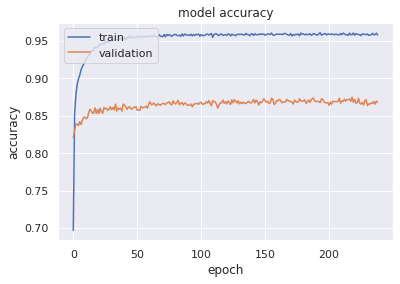

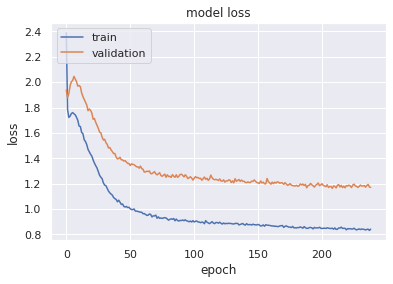

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_218148 in device /job:localhost/replica:0/task:0/d

{'Accuracy': 0.8624774658768993,
 'MCC': 0.8311064930665436,
 'log_loss': 0.4735180008766065,
 'f1 score weighted': 0.8628265353832723,
 'f1 score macro': 0.8765992183010223,
 'f1 score micro': 0.8624774658768994,
 'roc_auc ovr': 0.9794625900748828,
 'roc_auc ovo': 0.9830261844878541,
 'precision': 0.8643239730757046,
 'recall': 0.8624774658768993}

<Figure size 432x288 with 0 Axes>

In [8]:
dl=DeepML(x_train = x_train_std.astype(np.float32), y_train = y_train,x_test=x_test_std.astype(np.float32), y_test= y_test,
          number_classes=final_units, problem_type='multiclass',
          x_dval=x_dval_std.astype(np.float32), y_dval=y_dval, 
          epochs=500, batch_size=256,
          path='', report_name=None, verbose=1)

model = KerasClassifier(build_fn=dense_model, vector_size=vector_size, final_units = final_units)
deepen = dl.run_model(model)
scores, report, cm, cm2 = dl.model_complete_evaluate()
K.clear_session()
tf.keras.backend.clear_session()
scores

2º level 60 classes

In [10]:
data = get_ec_2_level_more_than_x_samples(phys_90, x=50, single_label=True) # column to consider is 'ec_number4
data, fps_x_phys, columns = physchemical(data)
fps_x_phys = fps_x_phys.drop(['ec_number2', 'ec_single_label', 'ec_number1', 'ec_to_keep'], axis=1) #9469 column
fps_x_phys = fps_x_phys.astype(np.float32) #reduce memory usage

fps_y = data['ec_single_label']
y_encoded, fps_y_hot, ecs = binarize_labels(fps_y)

print(fps_x_phys.shape)
print(y_encoded.shape)

counts = Counter(x for xs in fps_y for x in set(xs))
print(counts.most_common())

vector_size = fps_x_phys.shape[1] # 9469
# vector_size = len(columns)
final_units = fps_y_hot.shape[1] # 
print('vector_size', vector_size)
print('final_units', final_units)

#divide in train, validation and test
x_train, x_test, x_dval, y_train, y_test, y_dval = divide_dataset(fps_x_phys, y_encoded, test_size=0.2, val_size=0.2)

# normalization using the Training Set for both Training and Test would be as follows:
x_train_std, x_test_std, x_dval_std = normalization(x_train, x_test, x_dval)

(172150, 9469)
(172150,)
[('0', 22462), ('2.7', 19586), ('3.1', 11721), ('2.1', 10806), ('2.3', 7328), ('6.1', 7327), ('6.3', 7265), ('3.4', 7240), ('3.6', 6847), ('2.4', 6290), ('4.2', 5709), ('2.5', 4776), ('1.1', 4555), ('3.5', 4465), ('4.1', 4210), ('7.1', 4163), ('3.2', 3043), ('5.4', 2699), ('2.8', 2656), ('5.3', 2645), ('1.14', 2458), ('1.2', 2023), ('1.3', 1886), ('4.3', 1570), ('2.6', 1412), ('5.1', 1234), ('1.17', 1025), ('5.2', 985), ('1.4', 954), ('1.8', 909), ('1.11', 896), ('2.2', 847), ('4.6', 767), ('7.6', 760), ('6.5', 756), ('6.2', 740), ('1.7', 701), ('1.13', 559), ('7.2', 540), ('7.3', 465), ('1.9', 405), ('5.6', 399), ('0.0', 393), ('1.5', 380), ('1.18', 354), ('1.6', 332), ('1.15', 322), ('4.4', 279), ('1.10', 263), ('4.99', 259), ('7.5', 248), ('1.16', 188), ('1.97', 186), ('7.4', 162), ('3.3', 160), ('1.12', 124), ('3.7', 110), ('5.5', 98), ('1.21', 84), ('2.9', 63), ('6.4', 61)]
vector_size 9469
final_units 61


Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              9697280   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 7ms/step - loss: 2.1668 - accuracy: 0.8894 - val_loss: 2.5592 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 5/500
357/364 [============================>.] - ETA: 0s - loss: 2.1854 - accuracy: 0.8990Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDat

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 2s 7ms/step - loss: 2.2723 - accuracy: 0.9185 - val_loss: 2.7175 - val_accuracy: 0.8307 - lr: 0.0010
Epoch 13/500
360/364 [============================>.] - ETA: 0s - loss: 2.2464 - accuracy: 0.9210Executing op RangeDa

Epoch 20/500
364/364 [==============================] - ETA: 0s - loss: 2.1331 - accuracy: 0.9307Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 7ms/step - loss: 2.1331 - accuracy: 0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 2s 7ms/step - loss: 2.0035 - accuracy: 0.9369 - val_loss: 2.4893 - val_accuracy: 0.8383 - lr: 0.0010
Epoch 28/500
362/364 [============================>.] - ETA: 0s - loss: 1.9842 - accuracy: 0.9356Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 7ms/step - loss: 1.8932 - accuracy: 0.9361 - val_loss: 2.3614 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 36/500
360/364 [============================>.] - ETA: 0s - loss: 1.8199 - accuracy: 0.9436Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 9ms/step - loss: 1.7564 - accuracy: 0.9433 - val_loss: 2.2410 - val_accuracy: 0.8424 - lr: 0.0010
Epoch 44/500
357/364 [============================>.] - ETA: 0s - loss: 1.7736 - accuracy: 0.9400Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDa

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 7ms/step - loss: 1.6749 - accuracy: 0.9414 - val_loss: 2.1323 - val_accuracy: 0.8471 - lr: 0.0010
Epoch 59/500
356/364 [============================>.] - ETA: 0s - loss: 1.6126 - accuracy: 0.9490Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 9ms/step - loss: 1.5981 - accuracy: 0.9464 - val_loss: 2.0618 - val_accuracy: 0.8463 - lr: 0.0010
Epoch 67/500
356/364 [============================>.] - ETA: 0s - loss: 1.5704 - accuracy: 0.9489Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 7ms/step - loss: 1.5749 - accuracy: 0.9448 - val_loss: 2.0437 - val_accuracy: 0.8512 - lr: 0.0010
Epoch 75/500
364/364 [==============================] - ETA: 0s - loss: 1.5751 - accuracy: 0.9450Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDa

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 7ms/step - loss: 1.5559 - accuracy: 0.9449 - val_loss: 1.9885 - val_accuracy: 0.8532 - lr: 0.0010
Epoch 90/500
359/364 [============================>.] - ETA: 0s - loss: 1.5068 - accuracy: 0.9509Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 2s 7ms/step - loss: 1.4972 - accuracy: 0.9467 - val_loss: 1.9547 - val_accuracy: 0.8515 - lr: 0.0010
Epoch 98/500
361/364 [============================>.] - ETA: 0s - loss: 1.5029 - accuracy: 0.9477Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 9ms/step - loss: 1.4822 - accuracy: 0.9474 - val_loss: 1.9244 - val_accuracy: 0.8581 - lr: 0.0010
Epoch 106/500
356/364 [============================>.] - ETA: 0s - loss: 1.4708 - accuracy: 0.9487Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 7ms/step - loss: 1.4658 - accuracy: 0.9463 - val_loss: 1.9428 - val_accuracy: 0.8496 - lr: 0.0010
Epoch 121/500
357/364 [============================>.] - ETA: 0s - loss: 1.4798 - accuracy: 0.9462Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 2s 7ms/step - loss: 1.4733 - accuracy: 0.9457 - val_loss: 1.9094 - val_accuracy: 0.8554 - lr: 0.0010
Epoch 129/500
357/364 [============================>.] - ETA: 0s - loss: 1.4419 - accuracy: 0.9502Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 2s 7ms/step - loss: 1.4451 - accuracy: 0.9502 - val_loss: 1.8827 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 137/500
357/364 [============================>.] - ETA: 0s - loss: 1.4535 - accuracy: 0.9474Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 9ms/step - loss: 1.4280 - accuracy: 0.9475 - val_loss: 1.8617 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 152/500
356/364 [============================>.] - ETA: 0s - loss: 1.4216 - accuracy: 0.9488Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 2s 7ms/step - loss: 1.4304 - accuracy: 0.9471 - val_loss: 1.8624 - val_accuracy: 0.8590 - lr: 0.0010
Epoch 160/500
359/364 [============================>.] - ETA: 0s - loss: 1.4456 - accuracy: 0.9454Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 9ms/step - loss: 1.4075 - accuracy: 0.9475 - val_loss: 1.8445 - val_accuracy: 0.8597 - lr: 0.0010
Epoch 168/500
362/364 [============================>.] - ETA: 0s - loss: 1.4333 - accuracy: 0.9453Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 7ms/step - loss: 1.3880 - accuracy: 0.9483 - val_loss: 1.8530 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 183/500
356/364 [============================>.] - ETA: 0s - loss: 1.4025 - accuracy: 0.9470Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 9ms/step - loss: 1.3842 - accuracy: 0.9495 - val_loss: 1.8260 - val_accuracy: 0.8610 - lr: 0.0010
Epoch 191/500
357/364 [============================>.] - ETA: 0s - loss: 1.3730 - accuracy: 0.9489Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 7ms/step - loss: 1.3758 - accuracy: 0.9492 - val_loss: 1.8225 - val_accuracy: 0.8591 - lr: 0.0010
Epoch 199/500
361/364 [============================>.] - ETA: 0s - loss: 1.3886 - accuracy: 0.9470Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 2s 7ms/step - loss: 1.3720 - accuracy: 0.9481 - val_loss: 1.8137 - val_accuracy: 0.8577 - lr: 0.0010
Epoch 214/500
361/364 [============================>.] - ETA: 0s - loss: 1.3839 - accuracy: 0.9455Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 2s 7ms/step - loss: 1.3511 - accuracy: 0.9492 - val_loss: 1.8110 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 222/500
357/364 [============================>.] - ETA: 0s - loss: 1.3514 - accuracy: 0.9484Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 2s 7ms/step - loss: 1.3635 - accuracy: 0.9454 - val_loss: 1.8152 - val_accuracy: 0.8584 - lr: 0.0010
Epoch 230/500
360/364 [============================>.] - ETA: 0s - loss: 1.3444 - accuracy: 0.9485Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 2s 7ms/step - loss: 1.3491 - accuracy: 0.9463 - val_loss: 1.7837 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 245/500
361/364 [============================>.] - ETA: 0s - loss: 1.3478 - accuracy: 0.9464Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 2s 7ms/step - loss: 1.3359 - accuracy: 0.9472 - val_loss: 1.7843 - val_accuracy: 0.8552 - lr: 0.0010
Epoch 253/500
357/364 [============================>.] - ETA: 0s - loss: 1.3359 - accuracy: 0.9470Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 2s 7ms/step - loss: 1.3457 - accuracy: 0.9457 - val_loss: 1.7746 - val_accuracy: 0.8574 - lr: 0.0010
Epoch 261/500
360/364 [============================>.] - ETA: 0s - loss: 1.3244 - accuracy: 0.9493Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 2s 7ms/step - loss: 1.3194 - accuracy: 0.9467 - val_loss: 1.7625 - val_accuracy: 0.8609 - lr: 0.0010
Epoch 276/500
357/364 [============================>.] - ETA: 0s - loss: 1.3279 - accuracy: 0.9463Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 3s 7ms/step - loss: 1.3097 - accuracy: 0.9471 - val_loss: 1.7546 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 284/500
360/364 [============================>.] - ETA: 0s - loss: 1.3106 - accuracy: 0.9464Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
364/364 [==============================] - 2s 7ms/step - loss: 1.3122 - accuracy: 0.9457 - val_loss: 1.7587 - val_accuracy: 0.8596 - lr: 0.0010
Epoch 00291: early stopping
('Training Accuracy mean: ', 0.9429948299201494) 
 ('Validation Accuracy mean: ', 0.8525174671841651) 
 ('Training Loss mean: ', 1.5304966525933177) 
 ('Validation Loss mean: ', 1.9756001655998099)
Model: "sequential"
________________________________

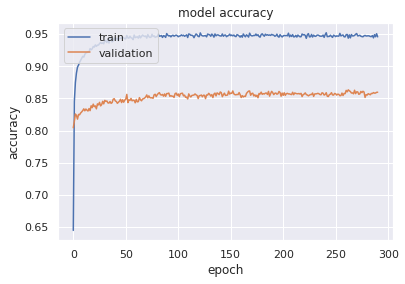

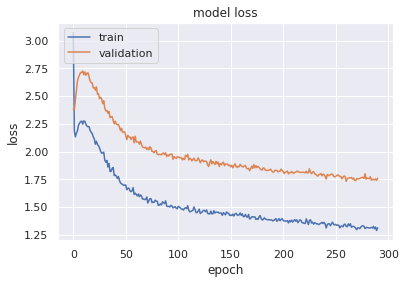

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_480221 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0

{'Accuracy': 0.8571594539645658,
 'MCC': 0.8485966157013858,
 'log_loss': 0.6152102683090821,
 'f1 score weighted': 0.8577966265394772,
 'f1 score macro': 0.8504946907817559,
 'f1 score micro': 0.8571594539645658,
 'roc_auc ovr': 0.9882143156942166,
 'roc_auc ovo': 0.9885065146127159,
 'precision': 0.8641119754013529,
 'recall': 0.8571594539645658}

<Figure size 432x288 with 0 Axes>

In [11]:
dl=DeepML(x_train = x_train_std.astype(np.float32), y_train = y_train,x_test=x_test_std.astype(np.float32), y_test= y_test,
          number_classes=final_units, problem_type='multiclass',
          x_dval=x_dval_std.astype(np.float32), y_dval=y_dval, 
          epochs=500, batch_size=256,
          path='', report_name=None, verbose=1)

model = KerasClassifier(build_fn=dense_model, vector_size=vector_size, final_units = final_units)
deepen = dl.run_model(model)
scores, report, cm, cm2 = dl.model_complete_evaluate()
K.clear_session()
tf.keras.backend.clear_session()
scores

3 º level - 158 classes

In [7]:
data = get_ec_3_level_more_than_x_samples(phys_90, x=50, single_label=True) # column to consider is 'ec_number4
data, fps_x_phys, columns = physchemical(data)
fps_x_phys = fps_x_phys.drop(['ec_single_label', 'ec_number3'], axis=1) #9469 column
fps_x_phys = fps_x_phys.astype(np.float32) #reduce memory usage

fps_y = data['ec_single_label']
y_encoded, fps_y_hot, ecs = binarize_labels(fps_y)

print(fps_x_phys.shape)
print(y_encoded.shape)

counts = Counter(x for xs in fps_y for x in set(xs))
print(counts.most_common())

vector_size = fps_x_phys.shape[1] # 9469
# vector_size = len(columns)
final_units = fps_y_hot.shape[1] # 
print('vector_size', vector_size)
print('final_units', final_units)

#divide in train, validation and test
x_train, x_test, x_dval, y_train, y_test, y_dval = divide_dataset(fps_x_phys, y_encoded, test_size=0.2, val_size=0.2)

# normalization using the Training Set for both Training and Test would be as follows:
x_train_std, x_test_std, x_dval_std = normalization(x_train, x_test, x_dval)

(165964, 9469)
(165964,)
[('0.0.0', 22855), ('2.1.1', 8059), ('6.1.1', 7318), ('2.7.7', 5941), ('2.3.1', 5115), ('2.5.1', 4768), ('2.7.1', 4384), ('4.2.1', 4290), ('1.1.1', 4121), ('7.1.1', 3157), ('3.6.4', 3043), ('2.4.1', 3030), ('2.7.11', 2828), ('2.4.2', 2712), ('4.1.1', 2673), ('3.1.3', 2590), ('3.6.1', 2464), ('3.2.1', 2398), ('3.1.1', 2295), ('2.7.4', 2282), ('6.3.2', 2275), ('5.3.1', 2249), ('3.5.1', 2115), ('3.4.21', 2072), ('6.3.4', 2052), ('6.3.5', 2029), ('2.8.1', 1787), ('2.3.2', 1746), ('1.2.1', 1727), ('3.1.26', 1672), ('2.1.2', 1495), ('3.5.4', 1327), ('5.4.99', 1277), ('2.7.2', 1274), ('3.4.24', 1264), ('2.6.1', 1235), ('2.1.3', 1216), ('2.7.8', 1118), ('4.2.3', 1043), ('5.4.2', 1021), ('3.6.5', 1013), ('5.2.1', 985), ('7.1.2', 979), ('1.11.1', 879), ('2.2.1', 847), ('1.3.1', 836), ('4.3.2', 783), ('4.6.1', 767), ('3.4.11', 762), ('7.6.2', 760), ('6.5.1', 743), ('6.2.1', 733), ('5.1.1', 733), ('2.8.4', 637), ('3.2.2', 600), ('3.4.22', 590), ('3.4.25', 578), ('4.1.99', 

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
351/351 [==============================] - 3s 10ms/step - loss: 2.3447 - accuracy: 0.8449 - val_loss: 2.4861 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 3/500
346/351 [============================>.] - ETA: 0s - loss: 2.2344 - accuracy: 0.8839Executing op RangeDa

Epoch 10/500
349/351 [============================>.] - ETA: 0s - loss: 2.4566 - accuracy: 0.9195Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
351/351 [==============================] - 2s 7ms/step - loss: 2.4570 - accuracy: 0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
351/351 [==============================] - 2s 7ms/step - loss: 2.4183 - accuracy: 0.9273 - val_loss: 2.8543 - val_accuracy: 0.8556 - lr: 0.0010
Epoch 18/500
345/351 [============================>.] - ETA: 0s - loss: 2.4707 - accuracy: 0.9242Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
351/351 [==============================] - 2s 7ms/step - loss: 2.4420 - accuracy: 0.9251 - val_loss: 2.8752 - val_accuracy: 0.8573 - lr: 0.0010
Epoch 26/500
346/351 [============================>.] - ETA: 0s - loss: 2.4037 - accuracy: 0.9337Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

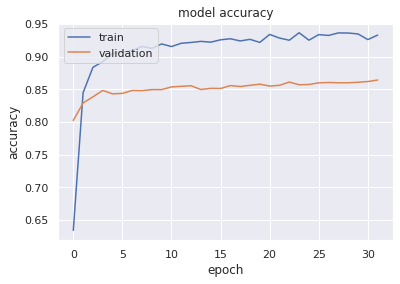

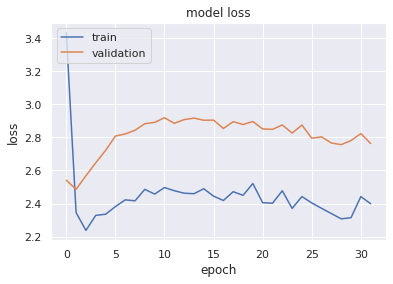

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_28939 in device /job:localhost/replica:0/task:0/de

{'Accuracy': 0.8635856957792306,
 'MCC': 0.8588374755976002,
 'log_loss': 0.6540973284285921,
 'f1 score weighted': 0.8641674705821886,
 'f1 score macro': 0.8420457245238488,
 'f1 score micro': 0.8635856957792306,
 'roc_auc ovr': 0.9916856166212568,
 'roc_auc ovo': 0.9916698602551958,
 'precision': 0.8759453627820583,
 'recall': 0.8635856957792306}

<Figure size 432x288 with 0 Axes>

In [8]:
dl=DeepML(x_train = x_train_std.astype(np.float32), y_train = y_train,x_test=x_test_std.astype(np.float32), y_test= y_test,
          number_classes=final_units, problem_type='multiclass',
          x_dval=x_dval_std.astype(np.float32), y_dval=y_dval, 
          epochs=500, batch_size=256,
          path='', report_name=None, verbose=1)

model = KerasClassifier(build_fn=dense_model, vector_size=vector_size, final_units = final_units)
deepen = dl.run_model(model)
scores, report, cm, cm2 = dl.model_complete_evaluate()
K.clear_session()
tf.keras.backend.clear_session()
scores

2. PFAM. To ease, the file with calculated features is given below. This dataset is already preprocessed. (To see how the features are calculated AMP notebooks can be checked)

In [5]:
pfam90 = pd.read_csv('/home/amsequeira/deepbio/datasets/ecpred/ecpred_uniprot_families_uniref_90.csv', low_memory=False)
pfam90

,From,To,uniref_90,Entry,Entry name,Status,Protein names,ec_number,Sequence,Cross-reference (Pfam),...,ec_8_3,ec_8_4,ec_9_1,ec_9_2,ec_9_3,ec_9_4,ec_10_1,ec_10_2,ec_10_3,ec_10_4
0,Q65GK1,UniRef90_Q65GK1,Q65GK1,Q65GK1,HEM3_BACLD,reviewed,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MRNIIVGSRRSKLAMTQTKWVIKKLEELNPDFTFEIKEIVTKGDRI...,PF01379;PF03900;,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P16616,UniRef90_P16616,P16616,P16616,HEM3_BACSU,reviewed,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MMRTIKVGSRRSKLAMTQTKWVIQKLKEINPSFAFEIKEIVTKGDR...,PF01379;PF03900;,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Q1LU25,UniRef90_Q1LU25,Q1LU25,Q1LU25,HEM3_BAUCH,reviewed,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MLNNILKIATRQSPLAIWQANYVRNQLLSFYPTLLIELVPIVTSGD...,PF01379;PF03900;,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q7VRM4,UniRef90_Q7VRM4,Q7VRM4,Q7VRM4,HEM3_BLOFL,reviewed,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MQAKILRIATRKSPLAICQACYVCNKLKHYHPHIQTELIPIITTGD...,PF01379;PF03900;,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Q491Z6,UniRef90_Q491Z6,Q491Z6,Q491Z6,HEM3_BLOPB,reviewed,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MKNKILKIATRKSQLAICQAQYVHNELKHYHPTLSIELMPIVTTGD...,PF01379;PF03900;,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175262,Q8R121,UniRef90_Q8R121,Q8R121,Q8R121,ZPI_MOUSE,reviewed,Protein Z-dependent protease inhibitor (PZ-dep...,0.0.0.0,MRVASSLFLPVLLTEVWLVTSFNLSSHSPEASVHLESQDYENQTWE...,PF00079;,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175263,Q3URR7,UniRef90_Q3URR7,Q3URR7,Q3URR7,ZSC10_MOUSE,reviewed,Zinc finger and SCAN domain-containing protein...,0.0.0.0,MLAEPVPDALEQEHPGAVKLEEDEVGEEDPRLAESRPRPEVAHQLF...,PF02023;PF00096;,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175264,P54479,UniRef90_P54479,P54479,P54479,ZUR_BACSU,reviewed,Zinc-specific metallo-regulatory protein,0.0.0.0,MNVQEALNLLKENGYKYTNKREDMLQLFADSDRYLTAKNVLSALND...,PF01475;,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175265,Q9VA00,UniRef90_Q9VA00,Q9VA00,Q9VA00,ZWILC_DROME,reviewed,Protein zwilch,0.0.0.0,MSASANLANVYAELMRRCGESYTITYGAPPTYLVSMVGAAEAGKKI...,PF09817;,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def dense_model(vector_size, final_units ):
    l1=1e-5
    l2=1e-4
    # with strategy.scope():
    model = Sequential()
    model.add(Input(shape=(vector_size,)))
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(final_units, activation = 'softmax'))
    print(model.summary())
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

PFAM 1º level - 8 classes

In [7]:

data = pfam90.dropna(subset=['Cross-reference (Pfam)']).reset_index()
data = get_ec_1_level(data, single_label=True)
data, fps_x, classes = hot_encoded_families(data)
fps_x=fps_x.astype(np.float32)
fps_y = data['ec_single_label']

y_encoded, fps_y_hot, ecs = binarize_labels(fps_y)


counts = Counter(x for xs in fps_y for x in set(xs))
counts.most_common()
df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df_sorted = df.sort_values(by=[0], ascending=False)
print(df_sorted)
x_train, x_test, x_dval, y_train, y_test, y_dval = \
    divide_dataset(fps_x, y_encoded, test_size=0.2, val_size=0.1)

vector_size = x_train.shape[1] # 700
final_units = fps_y_hot.shape[1]

print('vector_size', vector_size)
print('final_units', final_units)

#divide in train, validation and test
x_train, x_test, x_dval, y_train, y_test, y_dval = divide_dataset(fps_x, y_encoded, test_size=0.2, val_size=0.2)

  index      0
0     2  51530
3     3  33275
6     0  20535
2     1  18395
7     6  16064
1     4  12692
4     5   7896
5     7   6801
vector_size 9024
final_units 8


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 6ms/step - loss: 0.3353 - accuracy: 0.9635 - val_loss: 0.3200 - val_accuracy: 0.9646 - lr: 0.0010
Epoch 3/500
349/353 [============================>.] - ETA: 0s - loss: 0.2877 - accuracy: 0.9661Executing op RangeDat

Epoch 10/500
353/353 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.9670Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 6ms/step - loss: 0.2149 - accuracy: 0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 3s 7ms/step - loss: 0.1849 - accuracy: 0.9678 - val_loss: 0.2148 - val_accuracy: 0.9668 - lr: 0.0010
Epoch 18/500
344/353 [============================>.] - ETA: 0s - loss: 0.1853 - accuracy: 0.9680Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 6ms/step - loss: 0.1768 - accuracy: 0.9679 - val_loss: 0.2100 - val_accuracy: 0.9661 - lr: 0.0010
Epoch 26/500
344/353 [============================>.] - ETA: 0s - loss: 0.1758 - accuracy: 0.9678Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 6ms/step - loss: 0.1724 - accuracy: 0.9680 - val_loss: 0.2086 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 34/500
347/353 [============================>.] - ETA: 0s - loss: 0.1688 - accuracy: 0.9682Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDa

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 7ms/step - loss: 0.1640 - accuracy: 0.9682 - val_loss: 0.1946 - val_accuracy: 0.9659 - lr: 0.0010
Epoch 49/500
344/353 [============================>.] - ETA: 0s - loss: 0.1638 - accuracy: 0.9676Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 5ms/step - loss: 0.1632 - accuracy: 0.9679 - val_loss: 0.1943 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 57/500
345/353 [============================>.] - ETA: 0s - loss: 0.1652 - accuracy: 0.9675Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 5ms/step - loss: 0.1598 - accuracy: 0.9685 - val_loss: 0.1951 - val_accuracy: 0.9662 - lr: 0.0010
Epoch 65/500
349/353 [============================>.] - ETA: 0s - loss: 0.1590 - accuracy: 0.9684Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDa

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 5ms/step - loss: 0.1596 - accuracy: 0.9685 - val_loss: 0.1932 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 80/500
348/353 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9687Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 6ms/step - loss: 0.1578 - accuracy: 0.9678 - val_loss: 0.1881 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 88/500
349/353 [============================>.] - ETA: 0s - loss: 0.1581 - accuracy: 0.9680Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 6ms/step - loss: 0.1541 - accuracy: 0.9694 - val_loss: 0.1856 - val_accuracy: 0.9659 - lr: 0.0010
Epoch 96/500
344/353 [============================>.] - ETA: 0s - loss: 0.1531 - accuracy: 0.9692Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDa

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 6ms/step - loss: 0.1572 - accuracy: 0.9681 - val_loss: 0.1859 - val_accuracy: 0.9676 - lr: 0.0010
Epoch 111/500
344/353 [============================>.] - ETA: 0s - loss: 0.1538 - accuracy: 0.9685Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 6ms/step - loss: 0.1527 - accuracy: 0.9686 - val_loss: 0.1820 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 119/500
349/353 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9688Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 5ms/step - loss: 0.1544 - accuracy: 0.9680 - val_loss: 0.1883 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 127/500
353/353 [==============================] - ETA: 0s - loss: 0.1544 - accuracy: 0.9686Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 5ms/step - loss: 0.1537 - accuracy: 0.9681 - val_loss: 0.1827 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 142/500
351/353 [============================>.] - ETA: 0s - loss: 0.1517 - accuracy: 0.9689Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 5ms/step - loss: 0.1516 - accuracy: 0.9684 - val_loss: 0.1872 - val_accuracy: 0.9677 - lr: 0.0010
Epoch 150/500
351/353 [============================>.] - ETA: 0s - loss: 0.1569 - accuracy: 0.9680Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
353/353 [==============================] - 2s 5ms/step - loss: 0.1525 - accuracy: 0.9691 - val_loss: 0.1883 - val_accuracy: 0.9670 - lr: 0.0010
Epoch 158/500
345/353 [============================>.] - ETA: 0s - loss: 0.1536 - accuracy: 0.9687Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

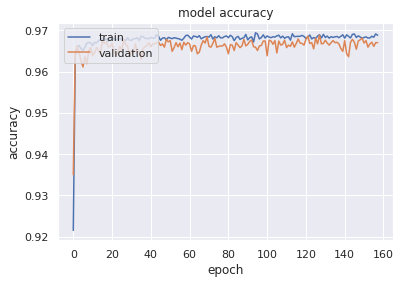

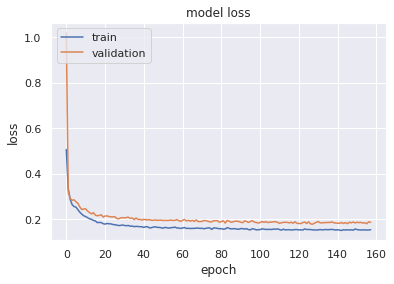

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_138679 in device /job:localhost/replica:0/task:0/d

{'Accuracy': 0.9648005263472695,
 'MCC': 0.9570641049271293,
 'log_loss': 0.13131688735605807,
 'f1 score weighted': 0.9648046962725738,
 'f1 score macro': 0.9586477341916092,
 'f1 score micro': 0.9648005263472695,
 'roc_auc ovr': 0.9973285742972273,
 'roc_auc ovo': 0.9974237525203264,
 'precision': 0.9649578632153709,
 'recall': 0.9648005263472695}

<Figure size 432x288 with 0 Axes>

In [8]:
dl=DeepML(x_train = x_train, y_train = y_train,x_test=x_test, y_test= y_test,
          number_classes=final_units, problem_type='multiclass',
          x_dval=x_dval, y_dval=y_dval, 
          epochs=500, batch_size=256,
          path='', report_name=None, verbose=1)

model = KerasClassifier(build_fn=dense_model, vector_size=vector_size, final_units = final_units)
deepen = dl.run_model(model)
scores, report, cm, cm2 = dl.model_complete_evaluate()
K.clear_session()
tf.keras.backend.clear_session()
scores

2º level - 60 classes

In [9]:
data = pfam90.dropna(subset=['Cross-reference (Pfam)']).reset_index()
data = get_ec_2_level_more_than_x_samples(data, x=50, single_label=True) # column to consider is 'ec_number4
data, fps_x, classes = hot_encoded_families(data)
fps_x=fps_x.astype(np.float32)
fps_y = data['ec_single_label']

y_encoded, fps_y_hot, ecs = binarize_labels(fps_y)


counts = Counter(x for xs in fps_y for x in set(xs))
counts.most_common()
df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df_sorted = df.sort_values(by=[0], ascending=False)
print(df_sorted)
x_train, x_test, x_dval, y_train, y_test, y_dval = \
    divide_dataset(fps_x, y_encoded, test_size=0.2, val_size=0.1)

vector_size = x_train.shape[1] # 700
final_units = fps_y_hot.shape[1]

print('vector_size', vector_size)
print('final_units', final_units)

#divide in train, validation and test
x_train, x_test, x_dval, y_train, y_test, y_dval = divide_dataset(fps_x, y_encoded, test_size=0.2, val_size=0.2)

   index      0
26   0.0  20535
11   2.7  18923
3    3.1  11147
21   2.1   9835
58   6.1   7327
6    2.3   7172
41   6.3   7064
7    3.4   7004
5    3.6   6845
10   2.4   5898
1    4.2   5623
0    2.5   4643
29   7.1   4531
16   1.1   4344
12   3.5   4281
19   4.1   4149
8    3.2   2942
40   5.4   2678
13   5.3   2566
20  1.14   2380
23   2.8   2219
25   1.2   1987
2    1.3   1829
14   4.3   1554
15   2.6   1404
28   5.1   1212
33  1.17   1027
52   5.2    944
34   1.4    926
27   1.8    897
32  1.11    839
42   2.2    838
22   7.6    770
49   6.5    743
35   6.2    734
45   4.6    730
24   1.7    699
9   1.13    547
17   7.2    466
53   7.3    465
46   5.6    396
30   1.5    356
54  1.18    344
47   1.6    318
56  1.15    306
50   4.4    264
4   4.99    259
48  1.10    258
51   7.5    248
31  1.16    179
36  1.97    171
37   7.4    164
38   3.3    155
18  1.12    109
39   3.7    108
43   5.5     86
44  1.21     84
59   2.9     63
55   1.9     59
57   6.4     59
vector_size 8956
final_u

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4585984   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
______________

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 7ms/step - loss: 0.3826 - accuracy: 0.9432 - val_loss: 0.4129 - val_accuracy: 0.9447 - lr: 0.0010
Epoch 5/500
346/348 [============================>.] - ETA: 0s - loss: 0.3752 - accuracy: 0.9431Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDat

Epoch 12/500
343/348 [============================>.] - ETA: 0s - loss: 0.3440 - accuracy: 0.9440Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 7ms/step - loss: 0.3439 - accuracy: 0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 5ms/step - loss: 0.3157 - accuracy: 0.9450 - val_loss: 0.3783 - val_accuracy: 0.9406 - lr: 0.0010
Epoch 20/500
347/348 [============================>.] - ETA: 0s - loss: 0.3171 - accuracy: 0.9451Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 5ms/step - loss: 0.3023 - accuracy: 0.9457 - val_loss: 0.3572 - val_accuracy: 0.9398 - lr: 0.0010
Epoch 28/500
345/348 [============================>.] - ETA: 0s - loss: 0.2978 - accuracy: 0.9463Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 5ms/step - loss: 0.2945 - accuracy: 0.9457 - val_loss: 0.3533 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 36/500
344/348 [============================>.] - ETA: 0s - loss: 0.2887 - accuracy: 0.9462Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDa

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 7ms/step - loss: 0.2786 - accuracy: 0.9466 - val_loss: 0.3372 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 51/500
348/348 [==============================] - ETA: 0s - loss: 0.2775 - accuracy: 0.9467Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 6ms/step - loss: 0.2727 - accuracy: 0.9468 - val_loss: 0.3264 - val_accuracy: 0.9440 - lr: 0.0010
Epoch 59/500
348/348 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.9468Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 6ms/step - loss: 0.2708 - accuracy: 0.9469 - val_loss: 0.3297 - val_accuracy: 0.9442 - lr: 0.0010
Epoch 67/500
348/348 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.9470Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDa

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 5ms/step - loss: 0.2675 - accuracy: 0.9462 - val_loss: 0.3233 - val_accuracy: 0.9448 - lr: 0.0010
Epoch 82/500
346/348 [============================>.] - ETA: 0s - loss: 0.2646 - accuracy: 0.9468Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 5ms/step - loss: 0.2645 - accuracy: 0.9465 - val_loss: 0.3259 - val_accuracy: 0.9440 - lr: 0.0010
Epoch 90/500
342/348 [============================>.] - ETA: 0s - loss: 0.2625 - accuracy: 0.9468Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 6ms/step - loss: 0.2661 - accuracy: 0.9466 - val_loss: 0.3318 - val_accuracy: 0.9448 - lr: 0.0010
Epoch 98/500
347/348 [============================>.] - ETA: 0s - loss: 0.2617 - accuracy: 0.9474Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDa

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 6ms/step - loss: 0.2603 - accuracy: 0.9470 - val_loss: 0.3224 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 113/500
343/348 [============================>.] - ETA: 0s - loss: 0.2625 - accuracy: 0.9462Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 6ms/step - loss: 0.2590 - accuracy: 0.9470 - val_loss: 0.3210 - val_accuracy: 0.9442 - lr: 0.0010
Epoch 121/500
343/348 [============================>.] - ETA: 0s - loss: 0.2577 - accuracy: 0.9478Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 5ms/step - loss: 0.2605 - accuracy: 0.9464 - val_loss: 0.3172 - val_accuracy: 0.9459 - lr: 0.0010
Epoch 129/500
340/348 [============================>.] - ETA: 0s - loss: 0.2581 - accuracy: 0.9473Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 5ms/step - loss: 0.2580 - accuracy: 0.9473 - val_loss: 0.3223 - val_accuracy: 0.9409 - lr: 0.0010
Epoch 144/500
348/348 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.9472Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 5ms/step - loss: 0.2574 - accuracy: 0.9462 - val_loss: 0.3124 - val_accuracy: 0.9468 - lr: 0.0010
Epoch 152/500
343/348 [============================>.] - ETA: 0s - loss: 0.2577 - accuracy: 0.9478Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 5ms/step - loss: 0.2559 - accuracy: 0.9471 - val_loss: 0.3223 - val_accuracy: 0.9442 - lr: 0.0010
Epoch 160/500
347/348 [============================>.] - ETA: 0s - loss: 0.2574 - accuracy: 0.9472Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 5ms/step - loss: 0.2562 - accuracy: 0.9468 - val_loss: 0.3176 - val_accuracy: 0.9435 - lr: 0.0010
Epoch 175/500
347/348 [============================>.] - ETA: 0s - loss: 0.2556 - accuracy: 0.9471Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
348/348 [==============================] - 2s 6ms/step - loss: 0.2564 - accuracy: 0.9474 - val_loss: 0.3175 - val_accuracy: 0.9448 - lr: 0.0010
Epoch 183/500
342/348 [============================>.] - ETA: 0s - loss: 0.2551 - accuracy: 0.9472Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

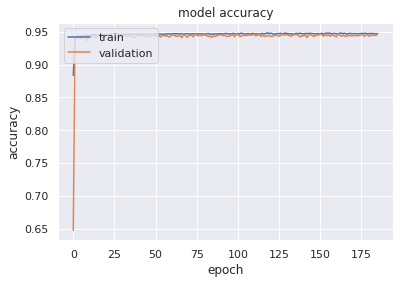

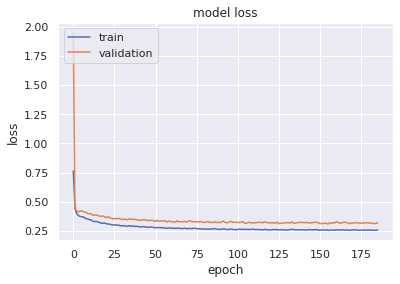

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_301359 in device /job:localhost/replica:0/task:0/d

{'Accuracy': 0.9449622051546704,
 'MCC': 0.9418324893671628,
 'log_loss': 0.20322019168905026,
 'f1 score weighted': 0.9443201812674846,
 'f1 score macro': 0.8637070947361019,
 'f1 score micro': 0.9449622051546704,
 'roc_auc ovr': 0.9977546693794207,
 'roc_auc ovo': 0.9966347111252313,
 'precision': 0.9483445444556571,
 'recall': 0.9449622051546704}

<Figure size 432x288 with 0 Axes>

In [10]:
dl=DeepML(x_train = x_train, y_train = y_train,x_test=x_test, y_test= y_test,
          number_classes=final_units, problem_type='multiclass',
          x_dval=x_dval, y_dval=y_dval, 
          epochs=500, batch_size=256,
          path='', report_name=None, verbose=1)

model = KerasClassifier(build_fn=dense_model, vector_size=vector_size, final_units = final_units)
deepen = dl.run_model(model)
scores, report, cm, cm2 = dl.model_complete_evaluate()
K.clear_session()
tf.keras.backend.clear_session()
scores

 3 º level - 157 classes

In [7]:
data = pfam90.dropna(subset=['Cross-reference (Pfam)']).reset_index()
data = get_ec_3_level_more_than_x_samples(data, x=50, single_label=True) # column to consider is 'ec_number4
data, fps_x, classes = hot_encoded_families(data)
fps_x=fps_x.astype(np.float32)
fps_y = data['ec_single_label']

y_encoded, fps_y_hot, ecs = binarize_labels(fps_y)


counts = Counter(x for xs in fps_y for x in set(xs))
counts.most_common()
df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df_sorted = df.sort_values(by=[0], ascending=False)
print(df_sorted)
x_train, x_test, x_dval, y_train, y_test, y_dval = \
    divide_dataset(fps_x, y_encoded, test_size=0.2, val_size=0.1)

vector_size = x_train.shape[1] # 700
final_units = fps_y_hot.shape[1]

print('vector_size', vector_size)
print('final_units', final_units)

#divide in train, validation and test
x_train, x_test, x_dval, y_train, y_test, y_dval = divide_dataset(fps_x, y_encoded, test_size=0.2, val_size=0.2)

      index      0
41    0.0.0  20535
151   6.1.1   7318
31    2.1.1   7120
45    2.7.7   5816
12    2.3.1   5043
..      ...    ...
131   5.3.2     56
91    1.3.8     55
51   1.3.99     54
36   1.1.99     54
5    1.3.98     52

[157 rows x 2 columns]
vector_size 8745
final_units 157


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.4935 - accuracy: 0.9310 - val_loss: 0.4991 - val_accuracy: 0.9351 - lr: 0.0010
Epoch 3/500
335/335 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.9341Executing op RangeDat

Epoch 10/500
327/335 [============================>.] - ETA: 0s - loss: 0.4087 - accuracy: 0.9363Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.4088 - accuracy: 0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 7ms/step - loss: 0.3835 - accuracy: 0.9367 - val_loss: 0.4394 - val_accuracy: 0.9379 - lr: 0.0010
Epoch 18/500
335/335 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.9373Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 7ms/step - loss: 0.3596 - accuracy: 0.9385 - val_loss: 0.4197 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 26/500
329/335 [============================>.] - ETA: 0s - loss: 0.3576 - accuracy: 0.9379Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.3480 - accuracy: 0.9372 - val_loss: 0.4036 - val_accuracy: 0.9395 - lr: 0.0010
Epoch 34/500
334/335 [============================>.] - ETA: 0s - loss: 0.3447 - accuracy: 0.9384Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDa

330/335 [============================>.] - ETA: 0s - loss: 0.3415 - accuracy: 0.9377Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.3416 - accuracy: 0.9377 - val_l

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.3300 - accuracy: 0.9381 - val_loss: 0.3952 - val_accuracy: 0.9391 - lr: 0.0010
Epoch 49/500
335/335 [==============================] - ETA: 0s - loss: 0.3311 - accuracy: 0.9381Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.3261 - accuracy: 0.9387 - val_loss: 0.3942 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 57/500
326/335 [============================>.] - ETA: 0s - loss: 0.3247 - accuracy: 0.9381Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.3216 - accuracy: 0.9386 - val_loss: 0.3877 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 65/500
328/335 [============================>.] - ETA: 0s - loss: 0.3241 - accuracy: 0.9383Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDa

327/335 [============================>.] - ETA: 0s - loss: 0.3209 - accuracy: 0.9383Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.3212 - accuracy: 0.9381 - val_l

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.3179 - accuracy: 0.9393 - val_loss: 0.3903 - val_accuracy: 0.9387 - lr: 0.0010
Epoch 80/500
335/335 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.9391Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDa

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.3113 - accuracy: 0.9392 - val_loss: 0.3803 - val_accuracy: 0.9378 - lr: 0.0010
Epoch 88/500
330/335 [============================>.] - ETA: 0s - loss: 0.3140 - accuracy: 0.9388Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDa

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 7ms/step - loss: 0.3107 - accuracy: 0.9385 - val_loss: 0.3724 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 96/500
334/335 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.9383Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDa

334/335 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.9386Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.3113 - accuracy: 0.9385 - val_l

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 5ms/step - loss: 0.3112 - accuracy: 0.9396 - val_loss: 0.3810 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 111/500
334/335 [============================>.] - ETA: 0s - loss: 0.3083 - accuracy: 0.9398Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.3111 - accuracy: 0.9389 - val_loss: 0.3850 - val_accuracy: 0.9399 - lr: 0.0010
Epoch 119/500
330/335 [============================>.] - ETA: 0s - loss: 0.3093 - accuracy: 0.9390Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.3081 - accuracy: 0.9393 - val_loss: 0.3800 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 127/500
329/335 [============================>.] - ETA: 0s - loss: 0.3111 - accuracy: 0.9394Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

332/335 [============================>.] - ETA: 0s - loss: 0.3059 - accuracy: 0.9398Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.3060 - accuracy: 0.9397 - val_l

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 5ms/step - loss: 0.3081 - accuracy: 0.9391 - val_loss: 0.3792 - val_accuracy: 0.9410 - lr: 0.0010
Epoch 142/500
335/335 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.9398Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapD

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
335/335 [==============================] - 2s 6ms/step - loss: 0.3070 - accuracy: 0.9385 - val_loss: 0.3762 - val_accuracy: 0.9387 - lr: 0.0010
Epoch 150/500
334/335 [============================>.] - ETA: 0s - loss: 0.3038 - accuracy: 0.9398Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorD

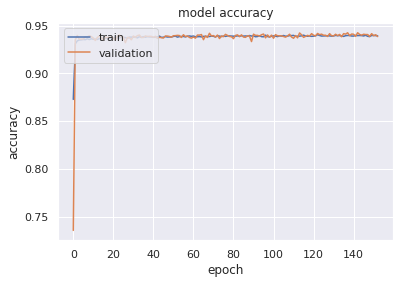

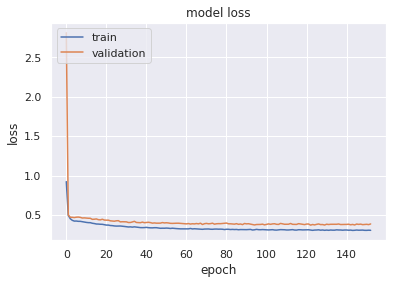

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_128314 in device /job:localhost/replica:0/task:0/d

{'Accuracy': 0.9369253054540874,
 'MCC': 0.9349030522895927,
 'log_loss': 0.2456418345736572,
 'f1 score weighted': 0.9358459828741648,
 'f1 score macro': 0.8556194315166199,
 'f1 score micro': 0.9369253054540874,
 'roc_auc ovr': 0.9977230998025406,
 'roc_auc ovo': 0.9972469590793404,
 'precision': 0.942458389575476,
 'recall': 0.9369253054540874}

<Figure size 432x288 with 0 Axes>

In [8]:
dl=DeepML(x_train = x_train, y_train = y_train,x_test=x_test, y_test= y_test,
          number_classes=final_units, problem_type='multiclass',
          x_dval=x_dval, y_dval=y_dval, 
          epochs=500, batch_size=256,
          path='', report_name=None, verbose=1)

model = KerasClassifier(build_fn=dense_model, vector_size=vector_size, final_units = final_units)
deepen = dl.run_model(model)
scores, report, cm, cm2 = dl.model_complete_evaluate()
K.clear_session()
tf.keras.backend.clear_session()
scores